### LIBRERÍAS

In [323]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from feature_engine.encoding import RareLabelEncoder,OneHotEncoder

import shap
from imblearn.over_sampling import SMOTE

### FUNCIONES

In [324]:
def data_year(year):
    """Función que almacena la info del año ingresado"""
    path = 'Data/'
    content = os.listdir(path)
    data_list = []
    for folder in content:
        try:
            if folder.index(year) > 0:
                content_l2 = os.listdir(f'{path}{folder}/')
                for folder2 in content_l2:
                    try:
                        if folder2.index('sdem') > 0:
                            path2 = f'{path}{folder}/{folder2}/conjunto_de_datos/'
                            content_l3 = os.listdir(f'{path2}')
                            #print(f'{path2}{content_l3[0]}')
                            data = pd.read_csv(f'{path2}{content_l3[0]}',
                                               encoding='latin',
                                               usecols = ['R_DEF','ENT','PAR_C','SEX','EDA','L_NAC_C','CS_P13_1','CS_P14_C','CS_P16','N_HIJ',
                                                          'E_CON','UR','CLASE1','CLASE2','HRSOCUP','HRSOCUP','INGOCUP']) 
                            # Variables descartadas: 'NAC_ANIO','EMP_PPAL','PER','ZONA','CS_P17'
                            #print('original',len(data), data.shape)
                            data = data[data['R_DEF']==0]
                            # Filtra los datos de interés
                            #print('completo',len(data))
                            data = data[(data['CS_P13_1']==7)|(data['CS_P13_1']==8)|(data['CS_P13_1']==9)]
                            #print('licenciaturas',len(data))
                            data_list.append(data)
                    except:
                        next
        except:
            next
    return pd.concat(data_list)

### EXTRACCIÓN DE LA INFORMACIÓN

In [325]:
data2018 = data_year('2018')

Columns (30) have mixed types.Specify dtype option on import or set low_memory=False.


In [326]:
data2019 = data_year('2019')

In [327]:
data2020 = data_year('2020')

In [328]:
data = pd.concat([data2018,data2019,data2020],ignore_index=True)

In [329]:
#data.to_csv('data.csv')

### REVISIÓN DEL DATA SET

In [330]:
data.shape

(473423, 16)

In [331]:
data.columns

Index(['R_DEF', 'ENT', 'PAR_C', 'SEX', 'EDA', 'L_NAC_C', 'CS_P13_1',
       'CS_P14_C', 'CS_P16', 'N_HIJ', 'E_CON', 'UR', 'CLASE1', 'CLASE2',
       'HRSOCUP', 'INGOCUP'],
      dtype='object')

In [332]:
data.dtypes

R_DEF         int64
ENT           int64
PAR_C       float64
SEX         float64
EDA         float64
L_NAC_C     float64
CS_P13_1    float64
CS_P14_C     object
CS_P16      float64
N_HIJ       float64
E_CON       float64
UR            int64
CLASE1        int64
CLASE2        int64
HRSOCUP       int64
INGOCUP       int64
dtype: object

In [333]:
#data = data.convert_dtypes()

In [334]:
#to_int = ['PAR_C','SEX','L_NAC_C','CS_P13_1','CS_P14_C','CS_P16','CS_P17','N_HIJ','E_CON']
#for col in to_int:
#    data[col] = pd.to_numeric(data[col],downcast='integer',errors= 'coerce')

In [335]:
#data.dtypes

### DEFINICIÓN DE VARIABLE OBJETIVO

In [336]:
# Defino campo target
pd.pivot_table(data,index = ['CLASE1','CLASE2'], values = ['HRSOCUP','INGOCUP'], aggfunc = 'mean')

HRSOCUP      INGOCUP
CLASE1 CLASE2                        
1      1       38.635385  6360.559097
       2        0.000000     0.000000
2      3        0.000000     0.000000
       4        0.000000     0.000000

In [337]:
# Clase1:
# 1 PEA, 
# 2 PNEA
# Personas de 12 años y más que durante el periodo de referencia no tuvieron ni realizaron una actividad 
# económica, ni buscaron desempeñar una en el último mes previo al día de la entrevista.
# Clase2: 
#  1 PoblaciÃ³n ocupada
#  2 PoblaciÃ³n desocupada
#  3 Disponibles
#  4 No disponibles
data['TARGET'] = np.where((data['CLASE1'] == 1)&(data['CLASE2'] == 1),1,0)
# 1 Ejerce
# 0 No Ejerce

In [338]:
#Para evitar colinealidad elimino las 2 columnas que me sirvieron para definir mi columna TARGET
# Aporvecho para eliminar R_DEF que sólo me ayudó a filtrar la info completa
data.drop(['CLASE1','CLASE2', 'R_DEF'], axis=1, inplace=True)

### REVISIÓN DE NULOS

In [339]:
data.isnull().sum()

ENT              0
PAR_C            0
SEX              0
EDA              0
L_NAC_C          0
CS_P13_1         0
CS_P14_C         0
CS_P16           0
N_HIJ       236700
E_CON            0
UR               0
HRSOCUP          0
INGOCUP          0
TARGET           0
dtype: int64

In [340]:
# Revisando si hay algún tipo de relación con el parentezco, 
# encontré que la categoría 101, 301, 409 corresponde a "Jefa o jefe, vive sola o solo", "Hija o hijo", "Nieta o nieto" asumiendo que no tienen hijos
# y la categoría 417 corresponden "Nuera o yerno",  
# por lo que se asume que al menos tiene un hijo o hija.
data[data['N_HIJ'].isnull()]['PAR_C'].value_counts()

101.0    127219
301.0     81511
201.0      8399
417.0      4483
409.0      4167
403.0      3290
501.0      2979
413.0      2037
418.0       740
414.0       523
303.0       474
401.0       452
415.0       143
412.0       107
421.0        41
302.0        35
402.0        23
419.0        21
410.0        20
202.0        16
999.0         6
701.0         5
406.0         3
423.0         2
420.0         1
405.0         1
615.0         1
422.0         1
Name: PAR_C, dtype: int64

In [341]:
# Asigno un 0 en N_HIJ a los que cumplen con esta característica 
data.loc[(data['N_HIJ'].isna() == True) & (data['PAR_C'] == 101),'N_HIJ'] = 0
data.loc[(data['N_HIJ'].isna() == True) & (data['PAR_C'] == 301),'N_HIJ'] = 0
data.loc[(data['N_HIJ'].isna() == True) & (data['PAR_C'] == 409),'N_HIJ'] = 0
data.loc[(data['N_HIJ'].isna() == True) & (data['PAR_C'] == 417),'N_HIJ'] = 1

In [342]:
data.isnull().sum()

ENT             0
PAR_C           0
SEX             0
EDA             0
L_NAC_C         0
CS_P13_1        0
CS_P14_C        0
CS_P16          0
N_HIJ       19320
E_CON           0
UR              0
HRSOCUP         0
INGOCUP         0
TARGET          0
dtype: int64

In [343]:
# Dado que aún quedaron nulos que no fue posible asignar y que represnetan sólo un 4% del total, decido eliminarlos
data.isnull().sum()['N_HIJ'] / len(data)

0.040809170657107915

In [344]:
data = data.dropna()

In [345]:
# Ya que la variable PAR_C sólo la necesitaba para aisgnar el número de hijos, ya la puedo eliminar
data.drop('PAR_C', axis=1, inplace = True)

In [346]:
# Finalmente lo que realmente me interessa es saber si tiene hijos o no y no la cantidad, entonces tranformo la columna a binaria 
data['N_HIJ'] = np.where(data['N_HIJ']>0, 1, 0)
data['N_HIJ'].value_counts()

0    319472
1    134631
Name: N_HIJ, dtype: int64

### REVISIÓN DE VARIABLES

In [347]:
numerics = ['HRSOCUP','INGOCUP','EDA']
categories = data.drop(['HRSOCUP','INGOCUP','EDA','TARGET'],axis=1).columns

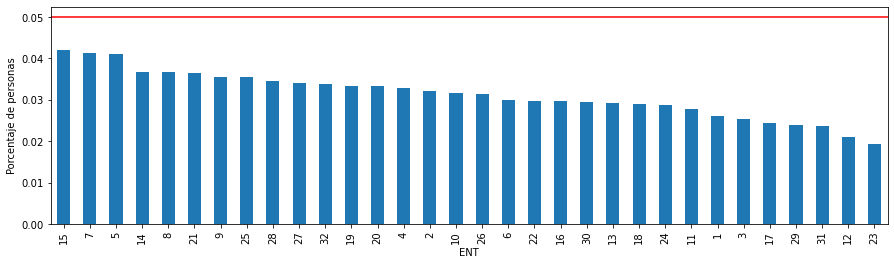

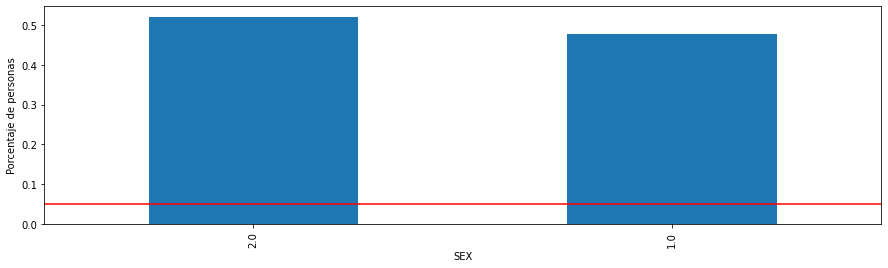

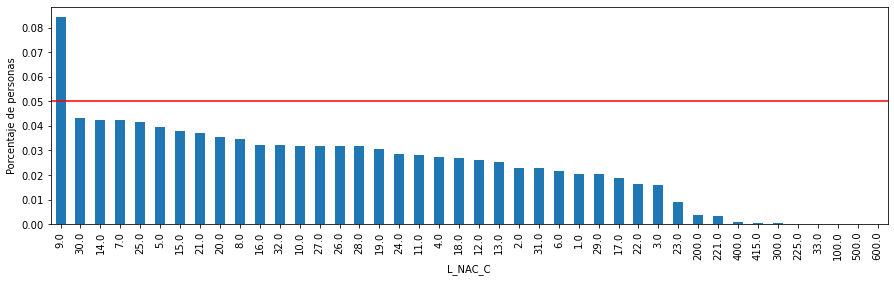

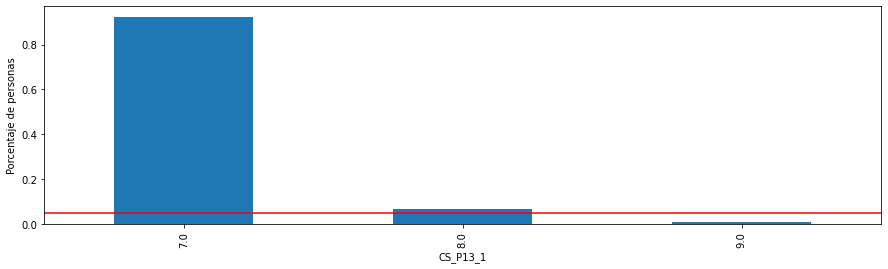

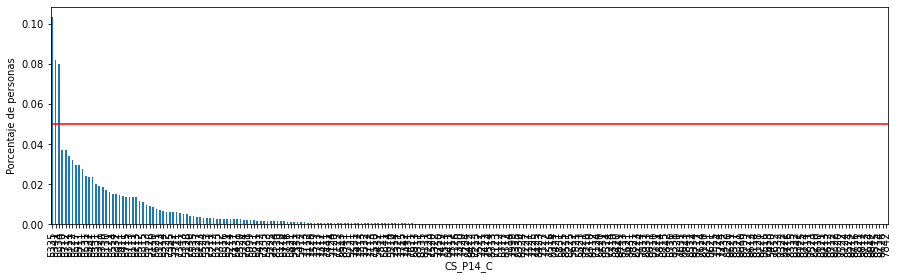

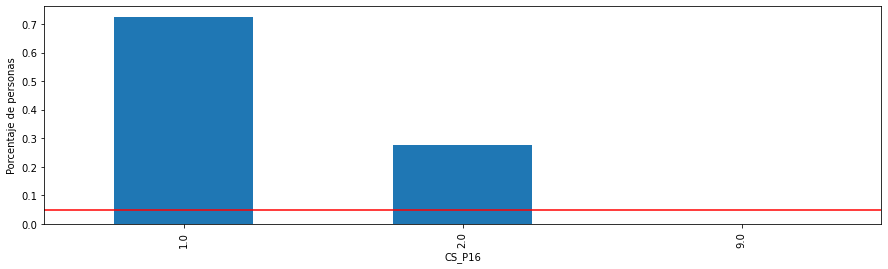

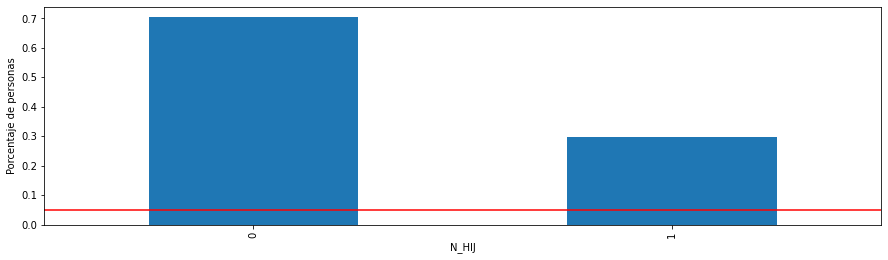

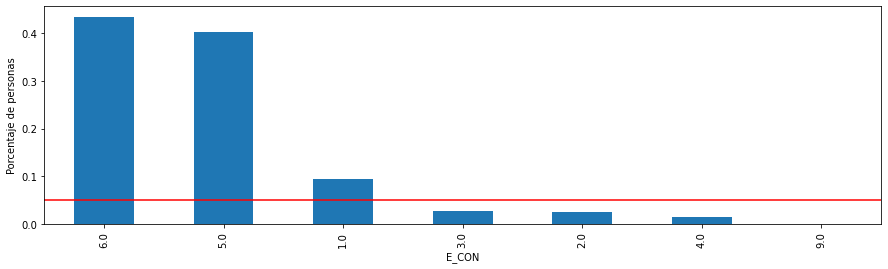

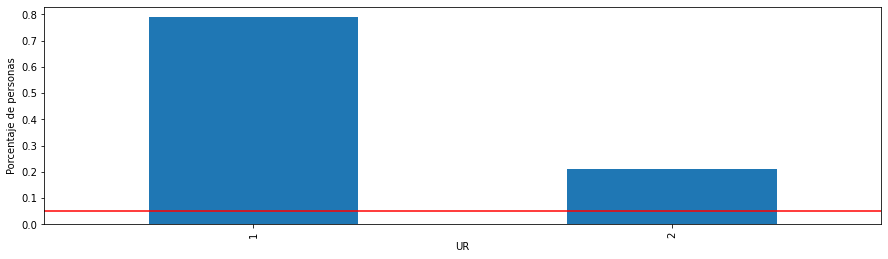

In [348]:
for col in categories:
    temp_df = pd.Series(data[col].value_counts() / len(data))
    plt.figure(figsize = (15,4))
    fig = temp_df.sort_values(ascending = False).plot.bar()
    fig.set_xlabel(col)
    
    fig.axhline(y=0.05, color='red')
    fig.set_ylabel('Porcentaje de personas')
    plt.show()

In [349]:
# Dado que hay una numerosa cantidad de códigos de carreras, lo reduzco al campo de las mismas
# Genero un diccionario con los campos amplios de las carreras de la Clasificación de Mexicana de Programas de Estudio (CMPE):
carrera = {'1':'Educación', 
           '2':'Artes y humanidades',
           '3':'Ciencias sociales, administración y derecho',
           '4':'Ciencias naturales, exactas y de la computación',
           '5':'Ingeniería, manufactura y construcción',
           '6':'Agronomía y veterinaria',
           '7':'Salud',
           '8':'Servicios',
           '9':'No especificado'}

In [350]:
data['CAMPO'] = pd.to_numeric(data['CS_P14_C'].apply(lambda x: x[1:2]))
#carrera[data.loc[:,'CS_P14_C'][1:2]]
data['CAMPO'].value_counts()

3    199971
5     91880
1     58372
7     47944
4     23677
2     17723
6     11325
8      2171
9      1040
Name: CAMPO, dtype: int64

In [351]:
data.drop('CS_P14_C', axis=1, inplace = True)

In [352]:
# Creación de columna para determinar si la entidad donde se toma la encuesta es la misma que la de nacimiento y determinar si se tuvo que mudar
data['ENT_ORIGEN'] = np.where(data['ENT'] == data['L_NAC_C'], 1, 0)
data['ENT_ORIGEN'].value_counts()

1    358478
0     95625
Name: ENT_ORIGEN, dtype: int64

In [353]:
# Dropeamos las columnas 'ENT' y 'L_NAC_C'
data.drop(['ENT','L_NAC_C'], axis=1, inplace = True)

In [354]:
# EL 2 y el 9 en la columna CS_P16 implica que No terminó la carrera o que No se proporcionó información por lo que se eliminan estos registros.
data = data[data['CS_P16']==1]

In [355]:
# EL 99 en la columna N_HIJ implica que no se proporcionó ibnformación por lo que se eliminan estos registros
data = data[data['N_HIJ']!=99]

In [356]:
# EL 9 en la columna E_CON implica que no se proporcionó información por lo que se eliminan estos registros
data = data[data['E_CON']!=9]

In [357]:
data.shape

(329221, 12)

In [358]:
# Revisión de variables númericas
data[numerics].describe()

,HRSOCUP,INGOCUP,EDA
count,329221.000000,329221.00000,329221.000000
mean,29.173470,5115.66035,40.997218
std,22.014082,8477.91179,13.583537
min,0.000000,0.00000,19.000000
25%,0.000000,0.00000,30.000000
50%,36.000000,0.00000,38.000000
75%,45.000000,8600.00000,50.000000
max,168.000000,300000.00000,98.000000


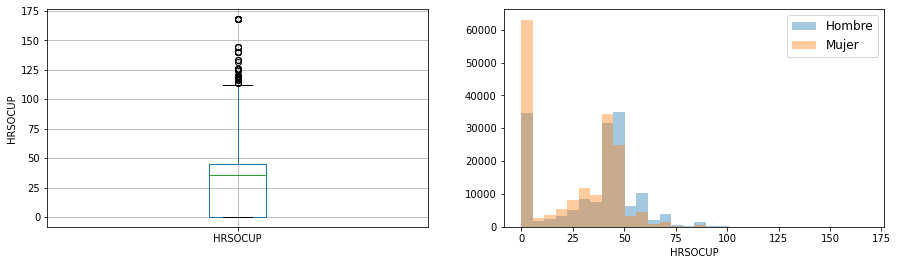

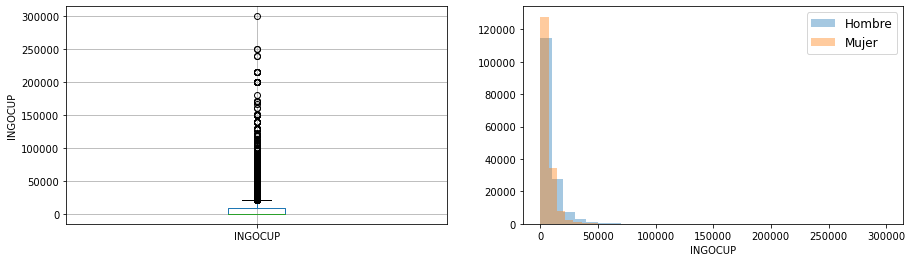

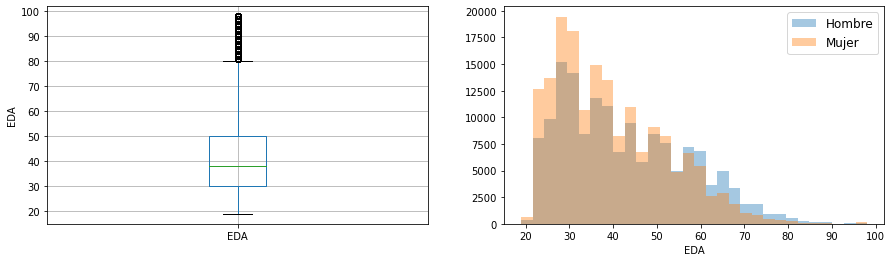

In [359]:
for col in numerics:
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    fig = data.boxplot(column = col)
    fig.set_ylabel(col)
    
    plt.subplot(1,2,2)
    fig = sns.distplot(data[data['SEX']==1][col], bins = 30, label='Hombre', kde = False)
    fig = sns.distplot(data[data['SEX']==2][col], bins = 30, label='Mujer', kde = False) #data[col].hist(bins = 30)
    plt.legend(prop={'size': 12})
    fig.set_xlabel(col)
    plt.show()

In [360]:
# Definimos el rango de edad de interés de los 22 a los 50  y sleccionamos los datos quedndome con el 75% del total del sataset
data_len = len(data)
data = data[(data['EDA']>21)&(data['EDA']<=50)]
len(data)/data_len

0.7502376822863669

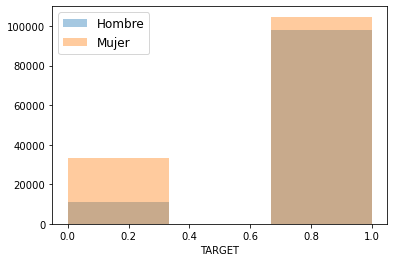

In [361]:
# REviso como quedó distribuida finalmente mi variable target
sns.distplot(data[data['SEX']==1]['TARGET'], bins = 3, label='Hombre', kde = False)
sns.distplot(data[data['SEX']==2]['TARGET'], bins = 3, label='Mujer', kde = False)
plt.legend(prop={'size': 12})
plt.show()

### REVISIÓN DE COLINEARIDAD

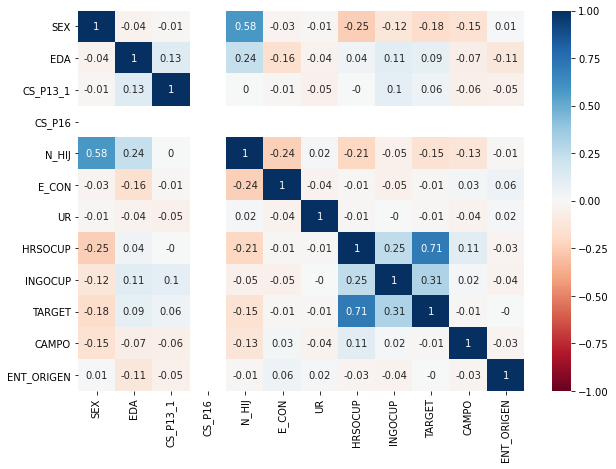

In [362]:
plt.figure(figsize=(10,7))
sns.heatmap(data.corr().round(2),  
           vmin = -1,
           vmax = 1,
           cmap = 'RdBu',
           annot =True);
# EMP_ PPAL, no hrs principal sólo con las posibles características

In [363]:
# Dada la alta coreralción de las variables de hora e ingreso, las elimino
data_final = data.drop(['HRSOCUP','INGOCUP'], axis=1)
#data_final['N_HIJ'] = data_final['N_HIJ'].astype("object")

In [364]:
len(data_final)

246994

In [365]:
data_final.to_csv('data_final.csv')

### PCA

In [366]:
from sklearn.decomposition import PCA

In [367]:
data_pca = data_final.drop('TARGET', axis=1)

In [368]:
pca = PCA()
pca.fit(data_pca)

PCA()

In [369]:
pca.explained_variance_ratio_

array([9.08070027e-01, 4.26195827e-02, 3.65503838e-02, 5.20217810e-03,
       2.54938526e-03, 2.34144671e-03, 1.42229526e-03, 1.24470144e-03,
       1.88226681e-37])

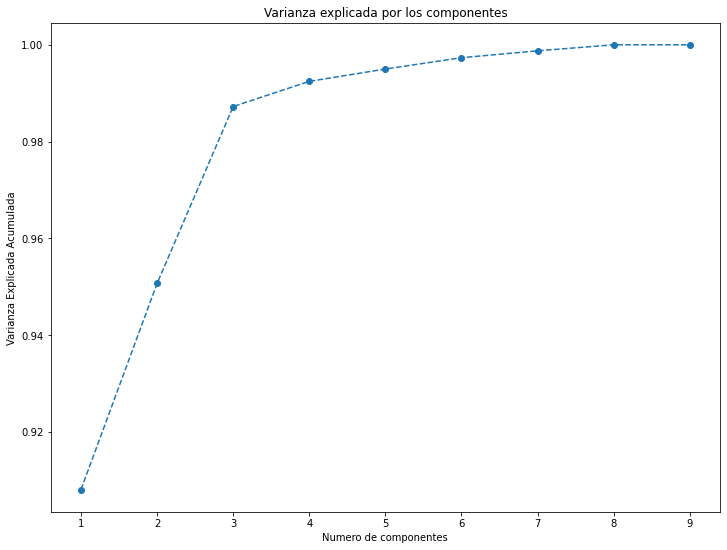

In [370]:
plt.figure(figsize=(12,9), facecolor='w')
plt.plot(range(1,len(data_pca.columns)+1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle="--")
plt.title("Varianza explicada por los componentes")
plt.xlabel("Numero de componentes")
plt.ylabel("Varianza Explicada Acumulada"); #Regla de oro es quedarnos con el 80% de la varianza

In [371]:
pca = PCA(n_components = 4)
pca.fit(data_pca)

PCA(n_components=4)

In [372]:
df_pca_comp = pd.DataFrame(data = pca.components_,
                           columns = data_pca.columns.values,
                           index = ['Componente Principal 1', 'Componente Principal 2', 'Componente Principal 3','Componente Principal 4']
                           )
df_pca_comp

,SEX,EDA,CS_P13_1,CS_P16,N_HIJ,E_CON,UR,CAMPO,ENT_ORIGEN
Componente Principal 1,-0.002446,0.999161,0.005336,-0.000000e+00,0.014893,-0.033425,-0.002208,-0.016398,-0.005413
Componente Principal 2,-0.051835,0.020781,-0.008343,0.000000e+00,-0.043009,0.120909,-0.011564,0.990020,-0.008346
Componente Principal 3,0.008219,-0.031985,-0.004615,-2.636780e-16,0.061952,-0.989559,0.010850,0.124622,-0.013241
Componente Principal 4,0.759503,-0.004761,-0.018181,1.110223e-16,0.644912,0.054429,-0.001527,0.061178,0.013541


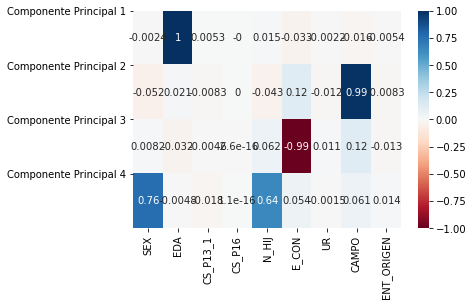

In [373]:
plt.figure(facecolor='w')
sns.heatmap(df_pca_comp, 
            vmin = -1,
            vmax = 1,
            cmap = 'RdBu',
            annot = True)
plt.yticks([0,1,2,3], ['Componente Principal 1', 'Componente Principal 2', 'Componente Principal 3','Componente Principal 4']);

Mis variables principales son la EDAD, el CAMPO de estudio y el Estado Conyugal

### Train and Test Split

In [374]:
X = data_final[['SEX','EDA','N_HIJ','E_CON','CAMPO']]
y = data_final['TARGET']

In [375]:
X, y = shuffle(X, y)

In [378]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)
X_train2, X_eval, y_train2, y_eval = train_test_split(X_train, y_train, test_size=0.3, random_state=0, stratify = y_train)

In [379]:
data_pipeline = Pipeline([('MinMaxScaler', MinMaxScaler())
                        ])

In [380]:
X_train_trans = data_pipeline.fit_transform(X_train)
X_test_trans = data_pipeline.transform(X_test)

In [381]:
# transform the dataset
oversample = SMOTE()
X_train_smote, y_train_smote = oversample.fit_resample(X_train_trans, y_train)

In [382]:
X_eval_trans = data_pipeline.transform(X_eval)

### LinearRegression

In [383]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve,roc_auc_score

In [384]:
lr_model = LogisticRegression(class_weight="balanced")
lr_model.fit(X_train_smote, y_train_smote)

LogisticRegression(class_weight='balanced')

In [385]:
y_pred_test = lr_model.predict(X_test_trans)

In [386]:
confusion_matrix(y_test, y_pred_test)

array([[ 6021,  2832],
       [17815, 22731]], dtype=int64)

In [387]:
accuracy_score(y_test, y_pred_test)

0.5820360736047289

In [388]:
print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.25      0.68      0.37      8853
           1       0.89      0.56      0.69     40546

    accuracy                           0.58     49399
   macro avg       0.57      0.62      0.53     49399
weighted avg       0.78      0.58      0.63     49399



0.6711088867390482

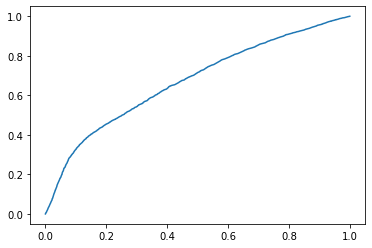

In [389]:
from sklearn import metrics
 
y_pred_proba = lr_model.predict_proba(X_test_trans)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
 
plt.plot(fpr,tpr);
auc

In [390]:
# Check overfitting
y_train_pred = lr_model.predict(X_train_trans)
confusion_matrix(y_train, y_train_pred)

array([[24069, 11341],
       [71548, 90637]], dtype=int64)

In [391]:
accuracy_score(y_train, y_train_pred)

0.5805106404514284

### Random Forest

In [392]:
from sklearn.ensemble import RandomForestClassifier

In [393]:
rf_model = RandomForestClassifier()

In [394]:
parameters = {
    'n_estimators': np.arange(10, 300, 150),
    'max_depth': np.arange(4,10,1),
}
gs = GridSearchCV(rf_model, parameters)
gs.fit(X_eval_trans, y_eval)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': array([4, 5, 6, 7, 8, 9]),
                         'n_estimators': array([ 10, 160])})

In [395]:
gs.best_params_, gs.best_score_

({'max_depth': 4, 'n_estimators': 10}, 0.8207965727916781)

In [396]:
best_params = gs.best_params_
#best_params = {'max_depth': 9, 'n_estimators': 160}

In [397]:
rf_model.set_params(**best_params)
rf_model.fit(X_train_smote, y_train_smote)

RandomForestClassifier(max_depth=4, n_estimators=10)

In [398]:
y_pred_test = rf_model.predict(X_test_trans)

In [399]:
confusion_matrix(y_test, y_pred_test)

array([[ 5992,  2861],
       [15419, 25127]], dtype=int64)

In [400]:
accuracy_score(y_test, y_pred_test)

0.6299520233203101

In [401]:
print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.28      0.68      0.40      8853
           1       0.90      0.62      0.73     40546

    accuracy                           0.63     49399
   macro avg       0.59      0.65      0.56     49399
weighted avg       0.79      0.63      0.67     49399



- Alta precision y alto recall: el modelo maneja perfectamente esa clase
- Alta precision y bajo recall: el modelo no detecta la clase muy bien, pero cuando lo hace es altamente confiable.
- Baja precisión y alto recall: La clase detecta bien la clase pero también incluye muestras de otras clases.
- Baja precisión y bajo recall: El modelo no logra clasificar la clase correctamente.

0.7044189535644285

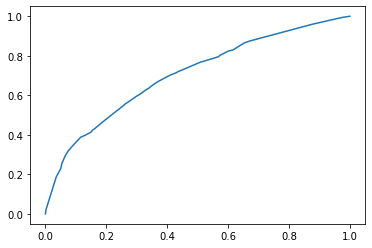

In [402]:
y_pred_proba = rf_model.predict_proba(X_test_trans)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
 
plt.plot(fpr,tpr);
auc

In [403]:
# Check overfitting
y_train_pred = rf_model.predict(X_train_trans)
confusion_matrix(y_train, y_train_pred)

array([[ 23858,  11552],
       [ 61365, 100820]], dtype=int64)

In [404]:
accuracy_score(y_train, y_train_pred)

0.6309775044915105

### Gaussian Naive Bayes

In [405]:
from sklearn.naive_bayes import GaussianNB

In [406]:
gnb_model = GaussianNB()
gnb_model.fit(X_train_smote, y_train_smote)

GaussianNB()

In [407]:
y_pred_test = gnb_model.predict(X_test_trans)

In [408]:
confusion_matrix(y_test, y_pred_test)

array([[ 6379,  2474],
       [19423, 21123]], dtype=int64)

In [409]:
accuracy_score(y_test, y_pred_test)

0.5567319176501548

In [410]:
print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.25      0.72      0.37      8853
           1       0.90      0.52      0.66     40546

    accuracy                           0.56     49399
   macro avg       0.57      0.62      0.51     49399
weighted avg       0.78      0.56      0.61     49399



0.670391304018124

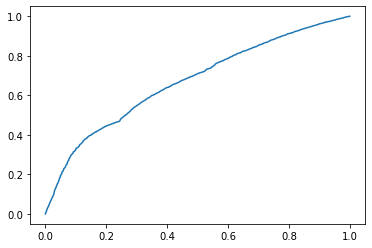

In [411]:
y_pred_proba = gnb_model.predict_proba(X_test_trans)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
 
plt.plot(fpr,tpr);
auc

In [412]:
# Check overfitting
y_train_pred = gnb_model.predict(X_train_trans)
confusion_matrix(y_train, y_train_pred)

array([[25643,  9767],
       [77458, 84727]], dtype=int64)

In [413]:
accuracy_score(y_train, y_train_pred)

0.5585667653533744

### K-Nearest Neighbors

In [414]:
from sklearn.neighbors import KNeighborsClassifier

In [415]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_smote, y_train_smote)

KNeighborsClassifier()

In [416]:
y_pred_test = knn_model.predict(X_test_trans)

In [417]:
confusion_matrix(y_test, y_pred_test)

array([[ 3318,  5535],
       [ 9972, 30574]], dtype=int64)

In [418]:
accuracy_score(y_test, y_pred_test)

0.6860867628899371

In [419]:
print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.25      0.37      0.30      8853
           1       0.85      0.75      0.80     40546

    accuracy                           0.69     49399
   macro avg       0.55      0.56      0.55     49399
weighted avg       0.74      0.69      0.71     49399



0.6190698827602125

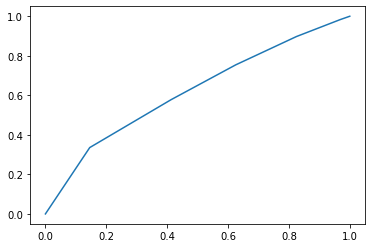

In [420]:
y_pred_proba = knn_model.predict_proba(X_test_trans)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
 
plt.plot(fpr,tpr);
auc

In [421]:
# Check overfitting
y_train_pred = knn_model.predict(X_train_trans)
confusion_matrix(y_train, y_train_pred)

array([[ 13461,  21949],
       [ 39160, 123025]], dtype=int64)

In [422]:
accuracy_score(y_train, y_train_pred)

0.6907361016220046

### Gradient Boosting

In [423]:
from lightgbm import LGBMClassifier

lgbm_model = LGBMClassifier()

In [424]:
parameters = {
    'learning_rate': np.arange(0.1, 1, 0.1),
    'max_depth':np.arange(2, 5, 1),
    'n_estimators': np.arange(10, 100, 10)}

gs = GridSearchCV(lgbm_model, parameters)
gs.fit(X_train_smote, y_train_smote, verbose=False)

GridSearchCV(estimator=LGBMClassifier(),
             param_grid={'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'max_depth': array([2, 3, 4]),
                         'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])})

In [425]:
gs.best_params_, gs.best_score_

({'learning_rate': 0.7000000000000001, 'max_depth': 4, 'n_estimators': 90},
 0.6784258716897371)

In [426]:
best_params = gs.best_params_
#best_params = {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 90}

In [427]:
# Los seleccionamos y entrenamos un modelo con estos valores
lgbm_model.set_params(**best_params)
lgbm_model.fit(X_train_smote, y_train_smote)

LGBMClassifier(learning_rate=0.7000000000000001, max_depth=4, n_estimators=90)

In [428]:
y_test_pred = lgbm_model.predict(X_test_trans)

In [429]:
confusion_matrix(y_test, y_test_pred)

array([[ 5910,  2943],
       [14183, 26363]], dtype=int64)

In [430]:
accuracy_score(y_test, y_test_pred)

0.6533128200975729

In [431]:
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.29      0.67      0.41      8853
           1       0.90      0.65      0.75     40546

    accuracy                           0.65     49399
   macro avg       0.60      0.66      0.58     49399
weighted avg       0.79      0.65      0.69     49399



0.7188968805222471

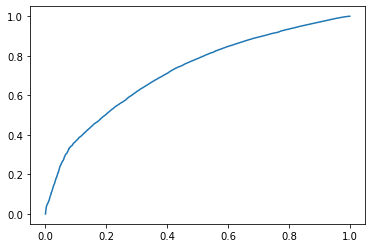

In [432]:
y_pred_proba = lgbm_model.predict_proba(X_test_trans)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
 
plt.plot(fpr,tpr);
auc

In [433]:
# Check overfitting
y_train_pred = lgbm_model.predict(X_train_trans)
confusion_matrix(y_train, y_train_pred)

array([[ 23874,  11536],
       [ 56143, 106042]], dtype=int64)

In [434]:
accuracy_score(y_train, y_train_pred)

0.6574862724259217

### CatBoostClassifier

In [435]:
from catboost import CatBoostClassifier

In [436]:
cb_model = CatBoostClassifier(iterations = 5000)

In [437]:
cb_model.fit(X_train_smote, y_train_smote)

Learning rate set to 0.027809
0:	learn: 0.6889578	total: 68.8ms	remaining: 5m 43s
1:	learn: 0.6849750	total: 132ms	remaining: 5m 29s
2:	learn: 0.6812575	total: 201ms	remaining: 5m 35s
3:	learn: 0.6777636	total: 272ms	remaining: 5m 40s
4:	learn: 0.6744467	total: 350ms	remaining: 5m 49s
5:	learn: 0.6713281	total: 417ms	remaining: 5m 47s
6:	learn: 0.6684156	total: 498ms	remaining: 5m 55s
7:	learn: 0.6656538	total: 579ms	remaining: 6m 1s
8:	learn: 0.6630378	total: 654ms	remaining: 6m 2s
9:	learn: 0.6605615	total: 727ms	remaining: 6m 2s
10:	learn: 0.6582321	total: 816ms	remaining: 6m 9s
11:	learn: 0.6560361	total: 888ms	remaining: 6m 9s
12:	learn: 0.6539630	total: 965ms	remaining: 6m 10s
13:	learn: 0.6520150	total: 1.05s	remaining: 6m 13s
14:	learn: 0.6501724	total: 1.12s	remaining: 6m 13s
15:	learn: 0.6484302	total: 1.2s	remaining: 6m 13s
16:	learn: 0.6467900	total: 1.28s	remaining: 6m 16s
17:	learn: 0.6452580	total: 1.36s	remaining: 6m 15s
18:	learn: 0.6437697	total: 1.43s	remaining: 6m 1

In [438]:
y_test_pred = cb_model.predict(X_test_trans)

In [439]:
confusion_matrix(y_test, y_test_pred)

array([[ 5951,  2902],
       [14335, 26211]], dtype=int64)

In [440]:
accuracy_score(y_test, y_test_pred)

0.6510658110488067

In [441]:
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.29      0.67      0.41      8853
           1       0.90      0.65      0.75     40546

    accuracy                           0.65     49399
   macro avg       0.60      0.66      0.58     49399
weighted avg       0.79      0.65      0.69     49399



0.7178554148390007

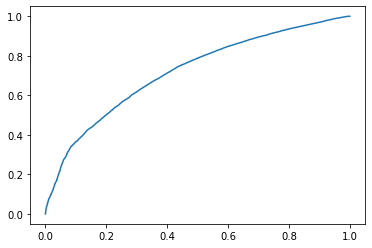

In [442]:
y_pred_proba = cb_model.predict_proba(X_test_trans)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
 
plt.plot(fpr,tpr);
auc

In [443]:
data_results = pd.concat([X_test.reset_index(drop=True),y_test.reset_index(drop = True),pd.Series(y_test_pred)], axis=1)

In [444]:
data_errors = data_results[data_results['TARGET']!=data_results[0]]
data_errors

,SEX,EDA,N_HIJ,E_CON,CAMPO,TARGET,0
9,1.0,45.0,0,5.0,5,0,1
13,2.0,29.0,1,2.0,3,1,0
17,2.0,26.0,0,6.0,3,1,0
19,1.0,40.0,0,6.0,3,0,1
23,2.0,25.0,1,6.0,2,0,1
...,...,...,...,...,...,...,...
49382,2.0,33.0,1,5.0,7,1,0
49383,2.0,41.0,1,3.0,1,0,1
49386,2.0,39.0,0,6.0,3,0,1
49392,2.0,50.0,1,5.0,5,1,0


In [445]:
data_errors[0].value_counts()

0    14335
1     2902
Name: 0, dtype: int64

In [446]:
data_results[data_results['TARGET']!=data_results[0]]['SEX'].value_counts()

2.0    13291
1.0     3946
Name: SEX, dtype: int64

In [447]:
data_results[data_results['TARGET']!=data_results[0]]['N_HIJ'].value_counts()

0    9006
1    8231
Name: N_HIJ, dtype: int64

In [448]:
data_results[data_results['TARGET']!=data_results[0]]['CAMPO'].value_counts()

3    8904
5    2599
7    2053
1    1663
4     974
2     793
6     186
8      42
9      23
Name: CAMPO, dtype: int64

### Explicabilidad del modelo

In [449]:
explainer_shap = shap.TreeExplainer(lgbm_model)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


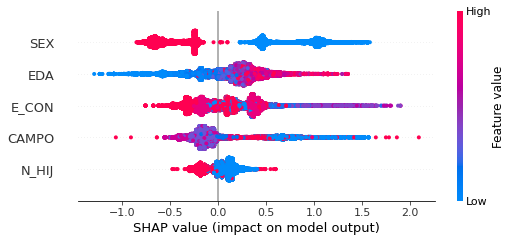

In [450]:
shap_values = explainer_shap.shap_values(X_test_trans)[1]
shap.summary_plot(shap_values, X_test, feature_names=X.columns.values)

- The y-axis indicates the variable name, in order of importance from top to bottom. 
- The value next to them is the mean SHAP value.
- On the x-axis is the SHAP value. Indicates how much is the change in log-odds. From this number we can extract the probability of success.
- Gradient color indicates the original value for that variable. In booleans, it will take two colors, but in number it can contain the whole spectrum.
- Each point represents a row from the original dataset.

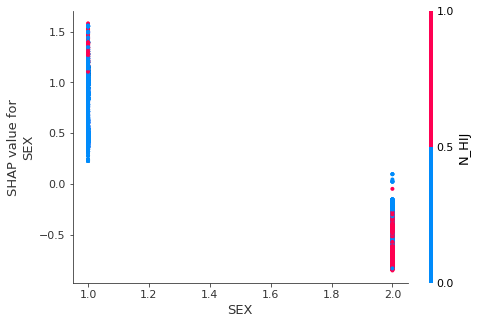

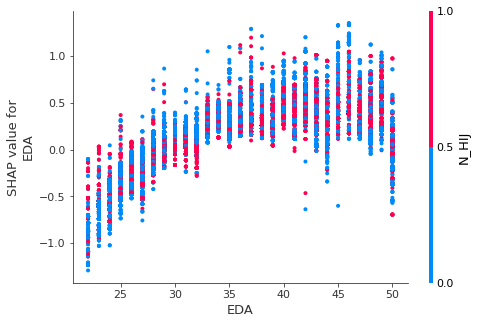

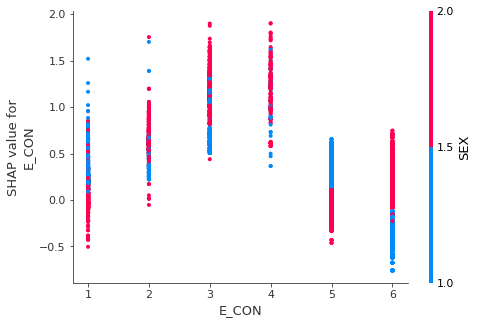

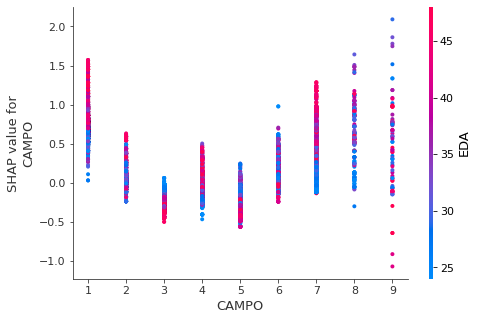

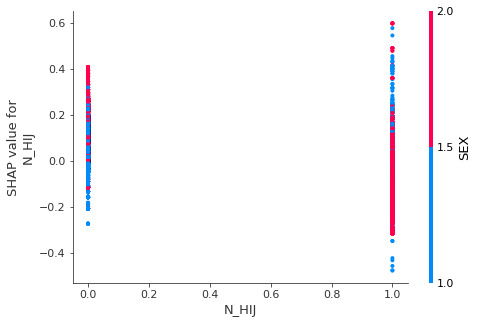

In [451]:
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))

for i in range(5):
    shap.dependence_plot(top_inds[i], shap_values, X_test, feature_names=X.columns.values)

In [452]:
shap.initjs()
shap.force_plot(
    base_value=0,
    shap_values=shap_values[:500],
    features=X_test,
    feature_names=X.columns.values,
    link='logit')

In [453]:
malign_index = list(y_test).index(0)
shap.force_plot(
    base_value=0,
    shap_values=shap_values[malign_index,:],
    features=X_test_trans[malign_index,:],
    feature_names=X.columns.values,
    link='logit')

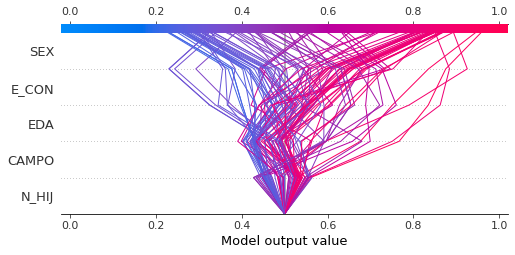

In [454]:
shap.decision_plot(0, shap_values[:100], features=X.columns.values, link='logit')